In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")


168052/168052 [==============================] - 1s 3us/step


In [7]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)


Citations shape: (5429, 2)


In [9]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)


Papers shape: (2708, 1435)


In [12]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])


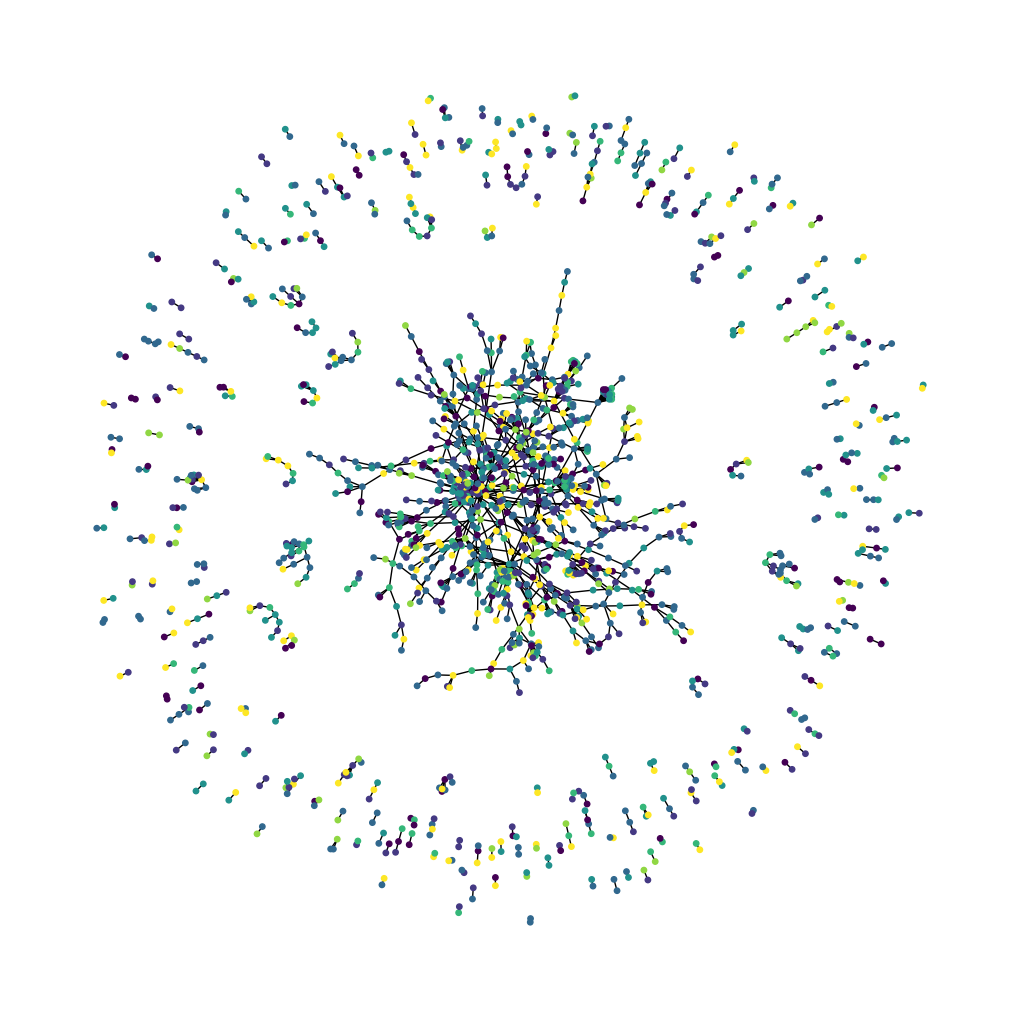

In [16]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


In [17]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (1330, 1435)
Test data shape: (1378, 1435)


In [18]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256


In [19]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [20]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [21]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [24]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[list(feature_names)].to_numpy()
x_test = test_data[list(feature_names)].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]


In [25]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

In [26]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 5s 109ms/step - loss: 4.0144 - acc: 0.1522 - val_loss: 1.9337 - val_acc: 0.1700
Epoch 2/300
5/5 [==============================] - 0s 19ms/step - loss: 2.6693 - acc: 0.2451 - val_loss: 1.9597 - val_acc: 0.1850
Epoch 3/300
5/5 [==============================] - 0s 19ms/step - loss: 2.5067 - acc: 0.2442 - val_loss: 1.9151 - val_acc: 0.2400
Epoch 4/300
5/5 [==============================] - 0s 17ms/step - loss: 2.2698 - acc: 0.2531 - val_loss: 1.8729 - val_acc: 0.2200
Epoch 5/300
5/5 [==============================] - 0s 18ms/step - loss: 1.9595 - acc: 0.3292 - val_loss: 1.8413 - val_acc: 0.2650
Epoch 6/300
5/5 [==============================] - 0s 18ms/step - loss: 1.8569 - acc: 0.3265 - val_loss: 1.8136 - val_acc: 0.3150
Epoch 7/300
5/5 [==============================] - 0s 17ms/step - loss: 1.7862 - acc: 0.3389 - val_loss: 1.7792 - val_acc: 0.3150
Epoch 8/300
5/5 [==============================] - 0s 16ms/step - loss: 1.7382 - acc: 0.3

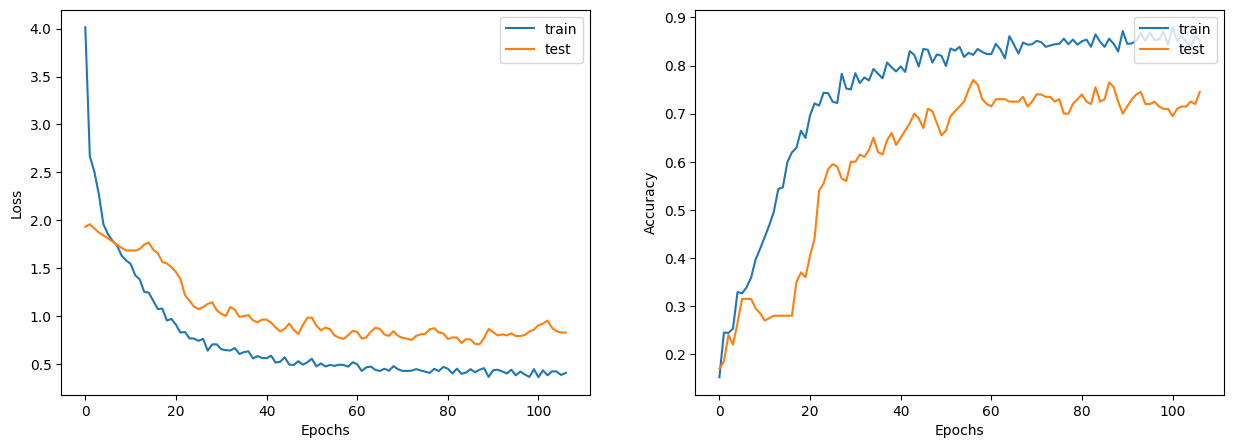

In [27]:
display_learning_curves(history)

In [28]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 73.08%


In [29]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [30]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)


1/1 [==============================] - 0s 293ms/step
Instance 1:
- Case_Based: 4.67%
- Genetic_Algorithms: 6.22%
- Neural_Networks: 63.86%
- Probabilistic_Methods: 7.47%
- Reinforcement_Learning: 5.93%
- Rule_Learning: 3.45%
- Theory: 8.4%
Instance 2:
- Case_Based: 7.38%
- Genetic_Algorithms: 28.01%
- Neural_Networks: 24.29%
- Probabilistic_Methods: 19.31%
- Reinforcement_Learning: 13.73%
- Rule_Learning: 4.33%
- Theory: 2.95%
Instance 3:
- Case_Based: 11.87%
- Genetic_Algorithms: 10.32%
- Neural_Networks: 19.54%
- Probabilistic_Methods: 23.65%
- Reinforcement_Learning: 22.65%
- Rule_Learning: 8.32%
- Theory: 3.66%
Instance 4:
- Case_Based: 2.6%
- Genetic_Algorithms: 6.46%
- Neural_Networks: 63.68%
- Probabilistic_Methods: 2.79%
- Reinforcement_Learning: 18.72%
- Rule_Learning: 1.44%
- Theory: 4.3%
Instance 5:
- Case_Based: 1.52%
- Genetic_Algorithms: 0.81%
- Neural_Networks: 44.33%
- Probabilistic_Methods: 47.23%
- Reinforcement_Learning: 1.74%
- Rule_Learning: 1.13%
- Theory: 3.24%
I

In [32]:
#graph now

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[list(feature_names)].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)


Edges shape: (2, 5429)
Nodes shape: (2708, 1433)
